##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [220]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Cleaning

In [221]:
train_df = pd.read_parquet(filepath)
print(train_df.shape)

(17992, 304)


In [222]:
train_df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


In [223]:
def data_cleaning(data):
    cols_to_drop = ["clntnum", "giclaim_cnt_success", "recency_giclaim_success", "giclaim_cnt_unsuccess", "recency_giclaim_unsuccess", "flg_gi_claim_29d435_ever", "flg_gi_claim_058815_ever", "flg_gi_claim_42e115_ever", "flg_gi_claim_856320_ever",
                    "flg_hlthclaim_14cb37_ever", "flg_hlthclaim_839f8a_ever",
                    "is_consent_to_mail", "is_consent_to_email", "is_consent_to_call", "is_consent_to_sms", "is_valid_dm", "is_valid_email", "is_housewife_retiree", "is_dependent_in_at_least_1_policy", "f_ever_declined_la"]
    #cols2 = ["ape_gi_42e115", "ape_ltc_1280bf", "ape_inv_dcd836", "ape_lh_d0adeb", "ape_gi_a10d1b", "ape_gi_29d435", "ape_gi_058815",
                    #"sumins_grp_22decf", "sumins_gi_a10d1b", "sumins_gi_29d435", "sumins_lh_e22a6a", "sumins_gi_856320", "sumins_grp_94baec", "sumins_gi_058815", "sumins_grp_e04c3a", "sumins_32c74c",
                    #"prempaid_gi_42e115", "prempaid_ltc_1280bf", "prempaid_inv_dcd836", "prempaid_lh_d0adeb", "prempaid_gi_a10d1b", "prempaid_gi_29d435", "prempaid_gi_058815",
                    #"ape_d0adeb", "f_hold_gi", "sumins_gi", "prempaid_d0adeb", "prempaid_gi", 'ape_gi_856320', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf', 'sumins_inv_dcd836', 'sumins_lh_d0adeb', 'prempaid_gi_856320', 'prempaid_32c74c', 'ape_gi']
    data.replace(to_replace=['None'], value=np.nan, inplace=True) # convert 'None' to NA to drop if needed
    data.replace(to_replace=[None], value=np.nan, inplace=True)
    data.dropna(subset=['min_occ_date', 'cltdob_fix'], inplace=True) # drop NA since 10 and 20 rows respectively
    data["f_purchase_lh"] = np.where(data["f_purchase_lh"] == 1, 1, 0) # convert to either 0 or 1
    data = data.drop(columns=cols_to_drop, errors='ignore') # initial EDA showed None for all rows

    data.loc[data.race_desc.isnull(), 'race_desc'] = 'Others'
    data["ctrycode_desc"] = np.where(data["ctrycode_desc"] == 'Singapore', 1, 0)
    data["cltsex_fix"] = np.where(data["cltsex_fix"] == 'Female', 0, 1)
    data = data.rename(columns={'ctrycode_desc': 'flg_sg', 'cltsex_fix': 'flg_male'})
    data['flg_substandard'] = np.where(data['flg_substandard'] == 1, 1, 0)
    data['annual_income_est'] = data['annual_income_est'].replace({'C.60K-100K': 80000, 'D.30K-60K' : 30000, 'A.ABOVE200K' : 200000, 'B.100K-200K' : 100000, 'E.BELOW30K': 0})
    data['hh_size_est'] = data['hh_size_est'].replace({'>4': 4})
    
    data['race_desc'] = data['race_desc'].astype(object)
    data['clttype'] = data['clttype'].astype(object)
    data['stat_flag'] = data['stat_flag'].astype(object)
    data.fillna(0, inplace=True)

    return data


In [224]:
train_df = data_cleaning(train_df)
print(train_df.head)
print('Proportion of likelihood buy', train_df['f_purchase_lh'].value_counts())

<bound method NDFrame.head of       race_desc  flg_sg clttype stat_flag min_occ_date  cltdob_fix  flg_male  \
19550   Chinese       1       P    ACTIVE   2017-10-31  1974-05-09         0   
4600    Chinese       1       P    ACTIVE   2007-05-23  1979-11-11         1   
13337    Others       1       P    ACTIVE   2019-08-31  1976-01-28         1   
15074   Chinese       1       P    ACTIVE   2021-10-18  1976-03-19         0   
19724   Chinese       1       P    ACTIVE   2018-07-20  1995-07-31         0   
...         ...     ...     ...       ...          ...         ...       ...   
11284    Others       1       P    LAPSED   2016-08-01  1994-05-24         1   
11964   Chinese       1       P    ACTIVE   1990-03-20  1948-12-16         1   
5390    Chinese       1       P    ACTIVE   2007-12-31  1967-12-06         0   
860      Others       1       P    ACTIVE   2007-09-01  1986-04-01         1   
15795    Indian       1       P    ACTIVE   2011-10-24  1970-05-15         1   

       fl

In [225]:
for i in train_df:
    print(i, train_df[i].unique())

race_desc ['Chinese' 'Others' 'Indian' 'Malay']
flg_sg [1 0]
clttype ['P' 'G' 'C']
stat_flag ['ACTIVE' 'LAPSED' 'MATURED']
min_occ_date ['2017-10-31' '2007-05-23' '2019-08-31' ... '2015-04-03' '2012-07-05'
 '1990-03-20']
cltdob_fix ['1974-05-09' '1979-11-11' '1976-01-28' ... '1948-12-16' '1967-12-06'
 '1970-05-15']
flg_male [0 1]
flg_substandard [0 1]
flg_is_borderline_standard [0. 1.]
flg_is_revised_term [0. 1.]
flg_is_rental_flat [0. 1.]
flg_has_health_claim [0. 1.]
flg_has_life_claim [0. 1.]
flg_gi_claim [0. 1.]
flg_is_proposal [0. 1.]
flg_with_preauthorisation [0. 1.]
flg_is_returned_mail [0. 1.]
is_sg_pr [1. 0.]
is_class_1_2 [1. 0.]
hh_20 ['144' '153' '62' '1' '114' '138' '131' '233' '109' '58' '107' '125' 0
 '68' '84' '102' '60' '221' '72' '112' '100' '59' '159' '90' '88' '81'
 '116' '82' '214' '92' '98' '191' '32' '44' '120' '101' '135' '94' '48'
 '211' '29' '127' '67' '35' '76' '70' '86' '33' '37' '148' '145' '26'
 '186' '40' '288' '108' '163' '219' '61' '78' '111' '93' '20' '2

In [226]:
train_df = train_df.drop(columns=['race_desc', 'clttype', 'stat_flag', 'min_occ_date', 'cltdob_fix'], errors='ignore')
train_df = train_df.astype(float)
train_df=(train_df-train_df.min())/(train_df.max()-train_df.min())
train_df.fillna(0, inplace=True)

In [227]:
for i in train_df:
    print(i, train_df[i].unique())

flg_sg [1. 0.]
flg_male [0. 1.]
flg_substandard [0. 1.]
flg_is_borderline_standard [0. 1.]
flg_is_revised_term [0. 1.]
flg_is_rental_flat [0. 1.]
flg_has_health_claim [0. 1.]
flg_has_life_claim [0. 1.]
flg_gi_claim [0. 1.]
flg_is_proposal [0. 1.]
flg_with_preauthorisation [0. 1.]
flg_is_returned_mail [0. 1.]
is_sg_pr [1. 0.]
is_class_1_2 [1. 0.]
hh_20 [0.26325411 0.2797075  0.11334552 0.00182815 0.20840951 0.25228519
 0.23948812 0.42595978 0.19926874 0.10603291 0.19561243 0.2285192
 0.         0.12431444 0.1535649  0.18647166 0.10968921 0.40402194
 0.13162706 0.2047532  0.18281536 0.10786106 0.29067642 0.16453382
 0.16087751 0.14808044 0.21206581 0.14990859 0.39122486 0.16819013
 0.17915905 0.34917733 0.05850091 0.08043876 0.21937843 0.18464351
 0.24680073 0.17184644 0.08775137 0.3857404  0.05301645 0.2321755
 0.12248629 0.06398537 0.13893967 0.12797075 0.15722121 0.06032907
 0.06764168 0.27056673 0.26508227 0.04753199 0.34003656 0.07312614
 0.52650823 0.19744059 0.29798903 0.40036563 

## Split into Train/Validation/Test sets & Oversampling

In [228]:
from sklearn.model_selection import train_test_split

y = train_df['f_purchase_lh']
X = train_df.drop('f_purchase_lh', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('Training data counts: ', X_train.shape)
print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of purchase likelihood  in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of purchase likelihood in testing data: \n', y_test.value_counts())

Training data counts:  (12212, 278)
Proportion of purchase likelihood in training data: 
 0.0    11742
1.0      470
Name: f_purchase_lh, dtype: int64
Validation data counts:  (3054, 278)
Proportion of purchase likelihood  in validation data: 
 0.0    2933
1.0     121
Name: f_purchase_lh, dtype: int64
Testing data counts:  (2694, 278)
Proportion of purchase likelihood in testing data: 
 0.0    2577
1.0     117
Name: f_purchase_lh, dtype: int64


In [229]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())

Proportion of purchase likelihood in training data: 
 0.0    11742
1.0    11742
Name: f_purchase_lh, dtype: int64


## Modelling

In [230]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on validation set: 0.76653569
True Neg: 2261 	 False Pos: 672
False Neg: 41 	 True Pos: 80
Precision on validation set: 0.10638298
Recall on validation set: 0.66115702
F1-Score on validation set: 0.18327606


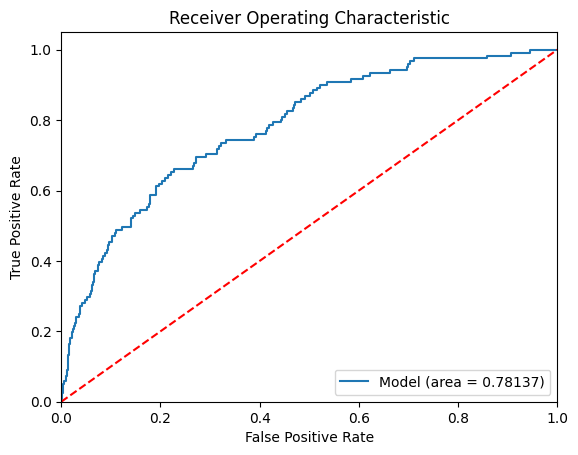

In [231]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

### Weighted Logistic Regression

In [ ]:
logwt_trainaccuracy = np.zeros(shape=(11))
logwt_testaccuracy = np.zeros(shape=(11))

for weight in range(0, 11):
  wt = 0.1*weight
  wts = {0:wt, 1:1-wt}
  logwt = LogisticRegression(class_weight = wts)
  logwt.fit(X_train,y_train)
  logwt_trainaccuracy[weight]= logwt.score(X_train, y_train)
  logwt_testaccuracy[weight]= logwt.score(X_valid, y_valid)

depths = range(0, 11)

# Plot and label the training and validation loss values
plt.plot(depths, logwt_trainaccuracy, label='Training Accuracy')
plt.plot(depths, logwt_testaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

Tried weighted logistic regression but it predicts the class with higher weights. (ie. sharp drop after 6 => class weights {0: 0.6, 1: 0.4} which causes the model to predict all as 0 and we have about 1/3 33% of 0 classes)

### Feature Selection Logistic Regression

In [ ]:
from sklearn.feature_selection import RFE

train_acc = np.zeros(shape=(20))
valid_acc = np.zeros(shape=(20))


for i in range(1, 20):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_train,y_train)
    train_acc[i - 1]= rfe.score(X_train, y_train)
    valid_acc[i - 1]= rfe.score(X_valid, y_valid)

depths = range(20)

# Plot and label the training and validation loss values
plt.plot(depths, train_acc, label='Training Accuracy')
plt.plot(depths, valid_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
d = valid_acc.argmax(axis=0) + 1
print(d)
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=d)
evaluate_model(rfe, X_train, y_train, X_valid, y_valid)

print(X_train.columns[rfe.support_])


## Decision Tree

Accuracy on validation set: 0.91879502
True Neg: 2783 	 False Pos: 150
False Neg: 98 	 True Pos: 23
Precision on validation set: 0.13294798
Recall on validation set: 0.19008264
F1-Score on validation set: 0.15646259


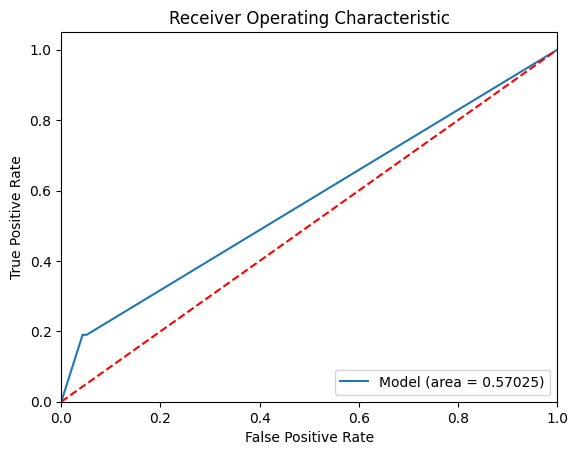

In [232]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
evaluate_model(tree, X_train, y_train, X_valid, y_valid)

### Max-Depth Decision Tree

In [ ]:
tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# max_depth = sqrt(d)
d = tree_validaccuracy.argmax(axis=0) + 1
print(d)
tree_depth = DecisionTreeClassifier(max_depth=d)
evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

Validation accuracy peaks at 34.

### Feature Selection Decision Tree

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_valid = X_valid[selected_feat]

dt_feat = DecisionTreeClassifier()
evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.94891945
True Neg: 2894 	 False Pos: 39
False Neg: 117 	 True Pos: 4
Precision on validation set: 0.09302326
Recall on validation set: 0.03305785
F1-Score on validation set: 0.04878049


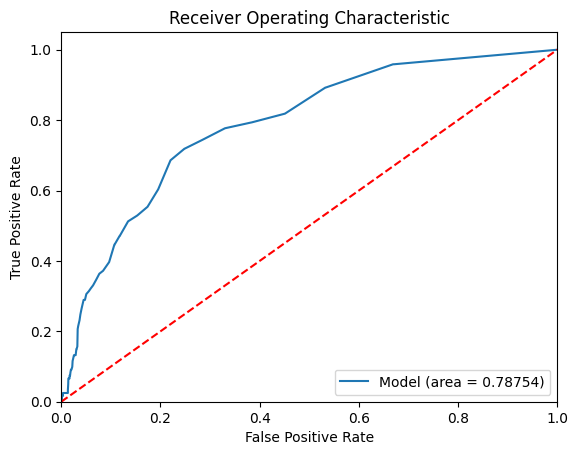

In [233]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
evaluate_model(forest, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

In [ ]:
forest_trainaccuracy = np.zeros(shape=(100))
forest_validaccuracy = np.zeros(shape=(100))
for max_d in range(1,100):
  rf = RandomForestClassifier(max_depth=max_d, random_state=42)
  rf.fit(X_train,y_train)
  forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
  forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

depths = range(0, 100)

# Plot and label the training and validation loss values
plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# max_depth = sqrt(d)
d = forest_validaccuracy.argmax(axis=0) + 1
print(d)
rf_depth = RandomForestClassifier(max_depth=d)
evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

In [ ]:
rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)
evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

In [ ]:
from numpy.random import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,7, step=1),
              'criterion':['gini','entropy'],
              'min_samples_leaf':np.arange(1,4,step=1),
              'min_samples_split':np.arange(2, 10, step=2)
          }

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   rs_space)

In [ ]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

In [ ]:
rf_rscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

Accuracy on validation set: 0.88703340
True Neg: 2673 	 False Pos: 260
False Neg: 85 	 True Pos: 36
Precision on validation set: 0.12162162
Recall on validation set: 0.29752066
F1-Score on validation set: 0.17266187


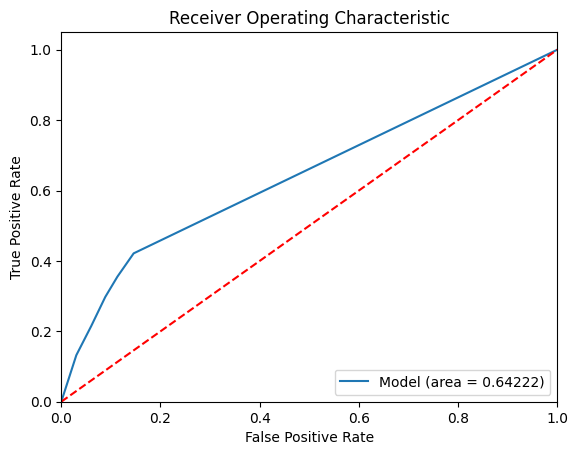

In [234]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

In [ ]:
kn_trainaccuracy = np.zeros(10)
kn_validaccuracy = np.zeros(10)
for k in range(1,11):
  kn = KNeighborsClassifier(n_neighbors=k)
  kn.fit(X_train,y_train)
  kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
  kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

depths = range(1, 11)

# Plot and label the training and validation loss values
plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
k = kn_validaccuracy.argmax(axis=0)
print(k)
knn_k = KNeighborsClassifier(n_neighbors=k)
evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

### KNN: feature selection

In [ ]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

sfs1 = sfs1.fit(X_train, y_train)


In [ ]:
print('Selected features:', sfs1.k_feature_idx_)
X_train_sfs = sfs1.transform(X_train)
X_valid_sfs = sfs1.transform(X_valid)
evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

In [235]:
from sklearn.decomposition import PCA

pca = PCA()
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_valid)
pca_explained_variance = pca.explained_variance_ratio_

print(pca_explained_variance)

[4.35515563e-01 1.10448101e-01 6.49858107e-02 5.67237327e-02
 3.79298115e-02 3.11547030e-02 2.65842516e-02 1.79684546e-02
 1.55153502e-02 1.43700877e-02 1.34220115e-02 1.21368783e-02
 1.11655141e-02 9.32357677e-03 8.67306154e-03 8.41746911e-03
 7.06032484e-03 6.71700305e-03 6.57078129e-03 6.08997917e-03
 5.48089509e-03 5.29908831e-03 5.03452699e-03 4.54845970e-03
 4.33479991e-03 4.19058643e-03 4.04004463e-03 3.59655274e-03
 3.30017274e-03 3.18617739e-03 3.05115830e-03 2.79152574e-03
 2.64748350e-03 2.23754591e-03 2.22349944e-03 2.07294738e-03
 1.95897180e-03 1.89770628e-03 1.84930944e-03 1.80868890e-03
 1.68090837e-03 1.40287533e-03 1.33703801e-03 1.29510052e-03
 1.18667246e-03 1.13949941e-03 1.09753845e-03 1.02245539e-03
 9.62846577e-04 8.88801115e-04 8.73153021e-04 8.17735832e-04
 7.99295506e-04 7.84534314e-04 7.56787261e-04 7.32279421e-04
 7.02802200e-04 6.64388974e-04 6.35139326e-04 6.11198746e-04
 6.02628993e-04 5.77840830e-04 5.49323743e-04 5.41096614e-04
 4.82441906e-04 4.556660

First component explains about 98% of the variance, second component about 1.4%

In [236]:
model_pca = PCA(n_components=2)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_valid = model_pca.transform(X_valid)

Accuracy on validation set: 0.70497708
True Neg: 2075 	 False Pos: 858
False Neg: 43 	 True Pos: 78
Precision on validation set: 0.08333333
Recall on validation set: 0.64462810
F1-Score on validation set: 0.14758751


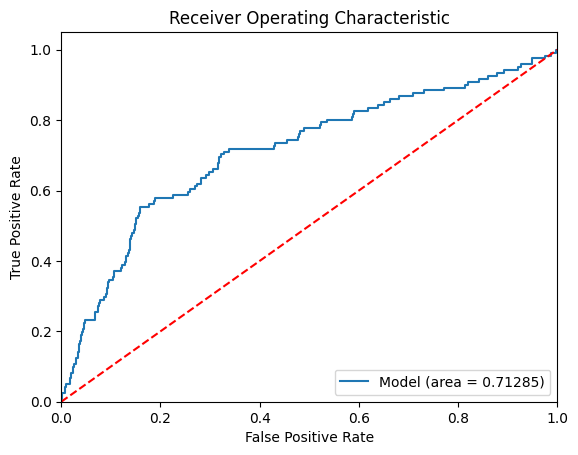

In [237]:
pca_logReg = LogisticRegression()
evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Accuracy on validation set: 0.93713163
True Neg: 2855 	 False Pos: 78
False Neg: 114 	 True Pos: 7
Precision on validation set: 0.08235294
Recall on validation set: 0.05785124
F1-Score on validation set: 0.06796117


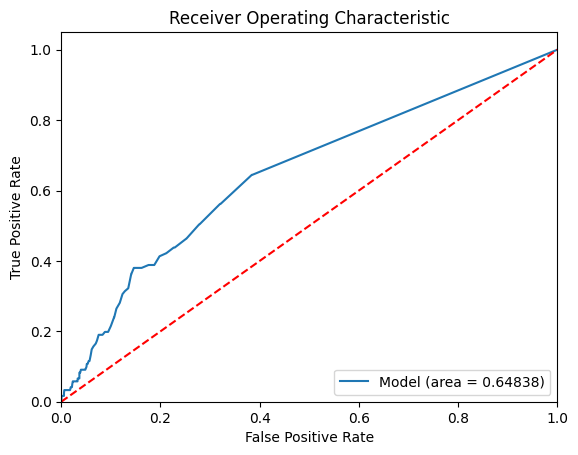

In [238]:
pca_tree = RandomForestClassifier()
evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

Accuracy on validation set: 0.86149312
True Neg: 2600 	 False Pos: 333
False Neg: 90 	 True Pos: 31
Precision on validation set: 0.08516484
Recall on validation set: 0.25619835
F1-Score on validation set: 0.12783505


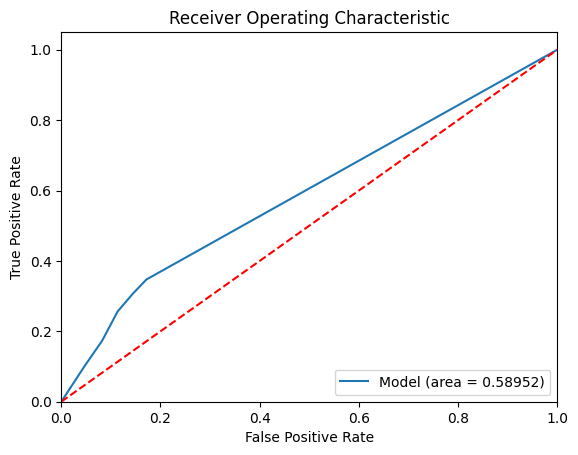

In [239]:
pca_knn = KNeighborsClassifier()
evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

Accuracy on validation set: 0.78094303
True Neg: 2315 	 False Pos: 618
False Neg: 51 	 True Pos: 70
Precision on validation set: 0.10174419
Recall on validation set: 0.57851240
F1-Score on validation set: 0.17305315


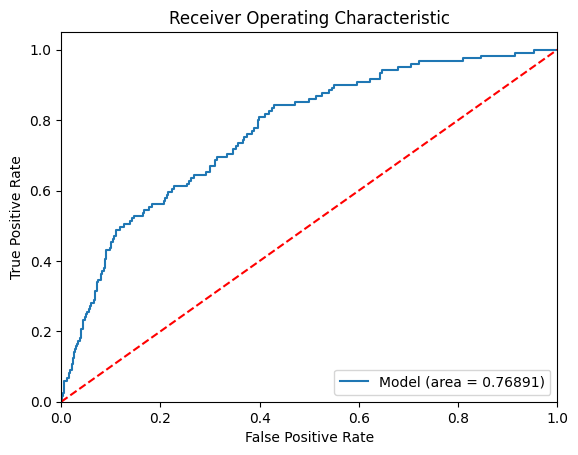

In [240]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on validation set: 0.11263916
True Neg: 238 	 False Pos: 2695
False Neg: 15 	 True Pos: 106
Precision on validation set: 0.03784363
Recall on validation set: 0.87603306
F1-Score on validation set: 0.07255305


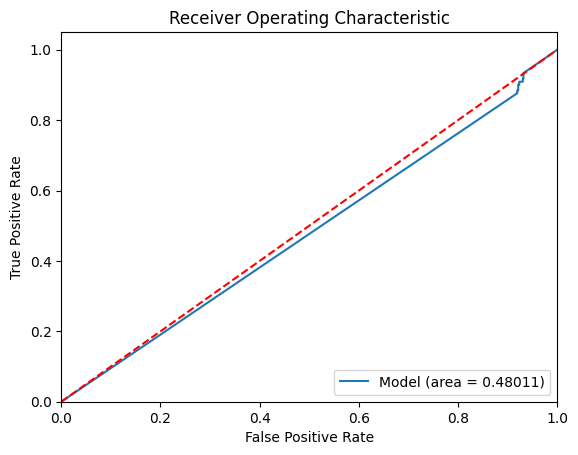

In [241]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [242]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

Precision of PLS-DA classifier on test set: 0.74
Precision of PLS-DA classifier on test set: 0.09
Recall of PLS-DA classifier on test set: 0.63


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!